# Solving Dynamic Maze with Q-Learning

TODO:  
1. whole maze as cnn input;  
2. cut it to grids and put it into different channels;  
3. instead of warm up, use pure e-greedy q-learning;
4. More self supervised?
5. Add the prior to the target q value
6. add explore new state terms to reward during warm up phase  

Warm up to get some signal from the goal state, and then use low epsilon q learning with HER (the furthest position as the additional goal).

In [2880]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# %matplotlib inline

from read_maze import load_maze, get_local_maze_information

`get_local_maze_information(x, y)` returns the information around location (y,x) (yes they are swapped...it should be `get_local_maze_information(row, col)`...) with shape (3,3,2), i.e. (row, col, info). info: [wall, fire_count]. If wall = 0, then there is a wall, otherwise that location is either empty or has a fire, which will last for fire_count rounds.

`around` is ordered as `around[row][col]`.

In [2881]:
# Load the maze (This should only be called ONCE in the entire program)
load_maze()

In [2883]:
class Environment:
    """
    Provides all functions to interact with the environment
    """
    def __init__(self, start_x=1, start_y=1, goal_x=199, goal_y=199):
        self.timestep = 0
        self.maze_size = 201
        self.goal_x = goal_x
        self.goal_y = goal_y
        self.maze = torch.zeros((self.maze_size, self.maze_size, 2))
        self.x = start_x
        self.y = start_y
        self.num_action = 5
        # Make initial observation
        self.around = torch.tensor(get_local_maze_information(self.y, self.x))
        self.update_maze()
    
    def update_maze(self):
        """Update the maze according to self.around and decrement fire"""
        self.maze[:, :, 1] = torch.where(self.maze[:, :, 1] > 0, self.maze[:, :, 1] - 1.0, self.maze[:, :, 1])
        self.maze[self.y-1:self.y+2, self.x-1:self.x+2] = self.around
     
    def get_legal_actions(self):
        """
        Return all legal actions from current state. 
        Illegal actions: Walk out of the maze, walk into the wall, walk into a fire.
        """
        # Stay
        legal_actions = [0]
        # # Left
        # if self.around[1][0][0] == 1 and self.x - 1 >= 0 and self.x - 1 < self.maze_size and self.y >= 0 and self.y < self.maze_size:
        #     legal_actions.append(1)
        # # Right
        # if self.around[1][2][0] == 1 and self.x + 1 >= 0 and self.x + 1 < self.maze_size and self.y >= 0 and self.y < self.maze_size:
        #     legal_actions.append(2)
        # # Up
        # if self.around[0][1][0] == 1 and self.x >= 0 and self.x < self.maze_size and self.y - 1 >= 0 and self.y - 1 < self.maze_size:
        #     legal_actions.append(3)
        # # Down
        # if self.around[2][1][0] == 1 and self.x >= 0 and self.x < self.maze_size and self.y + 1 >= 0 and self.y + 1 < self.maze_size:
        #     legal_actions.append(4)
        # Left
        if self.around[1][0][0] == 1 and self.around[1][0][1] == 0 and self.x - 1 >= 0 and self.x - 1 < self.maze_size and self.y >= 0 and self.y < self.maze_size:
            legal_actions.append(1)
        # Right
        if self.around[1][2][0] == 1 and self.around[1][2][1] == 0 and self.x + 1 >= 0 and self.x + 1 < self.maze_size and self.y >= 0 and self.y < self.maze_size:
            legal_actions.append(2)
        # Up
        if self.around[0][1][0] == 1 and self.around[0][1][1] == 0 and self.x >= 0 and self.x < self.maze_size and self.y - 1 >= 0 and self.y - 1 < self.maze_size:
            legal_actions.append(3)
        # Down
        if self.around[2][1][0] == 1 and self.around[2][1][1] == 0 and self.x >= 0 and self.x < self.maze_size and self.y + 1 >= 0 and self.y + 1 < self.maze_size:
            legal_actions.append(4)
        return legal_actions
    
    def get_next_position(self, action):
        """
        Return next position if action is taken. 
        Note that this is not really taking an action, the environment would not change.
        Also note that it does not care whether the action is legal or not.
        """
        if action == 0:  # Stay
            x = self.x
            y = self.y
        elif action == 1:  # Left
            x = self.x - 1
            y = self.y
        elif action == 2:  # Right
            x = self.x + 1
            y = self.y
        elif action == 3:  # Up
            x = self.x
            y = self.y - 1
        elif action == 4:  # Down
            x = self.x
            y = self.y + 1
        else:
            raise ValueError(f"Unknown Action: {action}")
        return x, y
            
    def make_action(self, action):
        """
        Take 1 of the following actions: stay, left, right, up, down. 
        Increment timestep.
        Update agent states (x, y, around, maze).

        Return a reward: 0 if game ends, -1 otherwise.
        """
        reward = -1.0

        # dist_to_goal = np.sqrt((self.goal_x - self.x) ** 2 + (self.goal_y - self.y) ** 2)

        if action not in self.get_legal_actions(): # If action is illegal, stay at current position and discount reward by 1
            action = 0
            reward -= 1

        self.x, self.y = self.get_next_position(action)
        
        # Update agent states
        self.timestep += 1
        self.around = torch.tensor(get_local_maze_information(self.y, self.x))
        self.update_maze()

        if self.game_end():
            return 0.0
        
        # new_dist_to_goal = np.sqrt((self.goal_x - self.x) ** 2 + (self.goal_y - self.y) ** 2)
        # if new_dist_to_goal < dist_to_goal:
        #     reward += 1
        # else:
        #     reward -= 1
        
        return reward
    
    def game_end(self):
        """Return True if agent reaches the bottom right corner"""
        if self.x == self.goal_x and self.y == self.goal_y: # 201 - 1 - wall
            return True
        return False
    
    def restart(self, x=1, y=1):
        """
        Move the agent to the starting position and reset all agent states related to the environment.
        Note that some fire might remain in the maze because we cannot call load_maze() again, 
        but they should be far away from the starting point so it does not really matter.
        """
        self.timestep = 0
        # self.maze = torch.zeros((self.maze_size, self.maze_size, 2))
        self.x = x
        self.y = y
        # Make initial observation
        self.around = torch.tensor(get_local_maze_information(self.y, self.x))
        self.update_maze()
    
    def print_surroundings(self):
        """Print out the surrounding 9 positions."""
        for y in range(3):
            for x in range(3):
                if x == 1 and y == 1:
                    print("X", end=" ")
                    continue
                if self.around[y][x][0] == 0:
                    print(u"\u2588", end=" ")
                if self.around[y][x][0] == 1 and self.around[y][x][1] > 0:
                    print(self.around[y][x][1].item(), end=" ")
                if self.around[y][x][0] == 1 and self.around[y][x][1] == 0:
                    print(" ", end=" ")
            print()

    def print_maze(self, x_low=0, y_low=0, size=15):
        """Print out the whole maze"""
        for y in range(y_low, y_low+size):
            for x in range(x_low, x_low+size):
                if x == self.x and y == self.y:
                    print("X", end=" ")
                    continue
                if self.maze[y][x][0] == 0:
                    print(u"\u2588", end=" ")
                if self.maze[y][x][0] == 1 and self.maze[y][x][1] > 0:
                    print(self.maze[y][x][1].int().item(), end=" ")
                if self.maze[y][x][0] == 1 and self.maze[y][x][1] == 0:
                    print(" ", end=" ")
            print()


In [2884]:
# def conv2d_size_out(size, kernel_size=3, stride=1):
#     return (size - (kernel_size - 1) - 1) // stride + 1
# conv_out_size = conv2d_size_out(conv2d_size_out(33))

class FeatureNetwork(nn.Module):
    def __init__(self, in_channel, out_channel):
        """out_channel: number of output channels in the last convolutional layer before being flattened and returned"""
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, 16, 3, padding="same")
        self.conv2 = nn.Conv2d(16, out_channel, 3, padding="same")

    def forward(self, state):
        feature = F.relu(self.conv1(state))
        feature = F.relu(self.conv2(feature))
        feature = feature.view(feature.shape[0], -1)
        return feature

class QNetwork(nn.Module):
    """
    Neural network to estimate the action-values.
    Input s, output q(s,a) for all a.
    """
    def __init__(self, feature_dim, num_action):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, 256)
        self.fc2 = nn.Linear(256, num_action)
    
    def forward(self, feature):
        output = F.relu(self.fc1(feature))
        output = self.fc2(output)
        return output


class NextStateNetwork(nn.Module):
    """
    Neural network to estimate the action-values.
    Input s, output q(s,a) for all a.
    """

    def __init__(self, feature_dim):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim+1, 256)
        self.fc2 = nn.Linear(256, feature_dim)

    def forward(self, feature_action):
        output = F.relu(self.fc1(feature_action))
        output = self.fc2(output)
        return output


class ActionNetwork(nn.Module):
    """
    Neural network to estimate the action-values.
    Input s, output q(s,a) for all a.
    """

    def __init__(self, feature_dim, num_action):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim*2, 256)
        self.fc2 = nn.Linear(256, num_action)

    def forward(self, feature_action):
        output = F.relu(self.fc1(feature_action))
        output = self.fc2(output)
        return output


In [2885]:
class QLearningAgent:
    """
    Agent that learns the optimal path to solve the maze using Q-Learning.
    """

    def __init__(self, env, target_update=10, batch_size=128, input_size=33, model=None, device='cpu'):
        # Environment
        self.env = env
        self.x = env.x
        self.y = env.y

        # For Exploration
        self.visited_times = torch.zeros((self.env.maze_size, self.env.maze_size))
        self.state_action_visited_times = torch.zeros((self.env.maze_size, self.env.maze_size, self.env.num_action))
        self.last_visited_timestep = torch.zeros((self.env.maze_size, self.env.maze_size))

        # Training set up
        self.batch_size = batch_size
        self.target_update = target_update # Timesteps between target network update
        self.input_size = input_size # Size of feature_net input
        self.out_channel = 32
        self.feature_dim = self.out_channel * self.input_size ** 2
        self.device = device
        self.replay_buffer = [] # list of tuples: (state, action, next_state, reward, done)

        # Define networks
        self.feature_net = FeatureNetwork(self.get_state(self.y, self.x).shape[0], self.out_channel).to(device)
        self.feature_optimizer = optim.Adam(self.feature_net.parameters(), lr=1e-4)
        self.q_net = QNetwork(feature_dim=self.feature_dim, num_action=self.env.num_action).to(device)
        self.q_optimizer = optim.Adam(self.q_net.parameters(), lr=1e-4)
        self.next_state_net = NextStateNetwork(feature_dim=self.feature_dim).to(device)
        self.next_state_optimizer = optim.Adam(self.next_state_net.parameters(), lr=1e-4)
        self.action_net = ActionNetwork(feature_dim=self.feature_dim, num_action=self.env.num_action).to(device)
        self.action_optimizer = optim.Adam(self.action_net.parameters(), lr=1e-4)
        
        if model is not None:
            model_info = torch.load(model, map_location=self.device)
            self.feature_net.load_state_dict(model_info["feature_net"])
            self.feature_optimizer.load_state_dict(model_info["feature_optimizer"])
            self.q_net.load_state_dict(model_info["q_net"])
            self.q_optimizer.load_state_dict(model_info["q_optimizer"])
            self.next_state_net.load_state_dict(model_info["next_state_net"])
            self.next_state_optimizer.load_state_dict(model_info["next_state_optimizer"])
            self.action_net.load_state_dict(model_info["action_net"])
            self.action_optimizer.load_state_dict(model_info["action_optimizer"])
        
        self.target_feature_net = FeatureNetwork(self.get_state(self.y, self.x).shape[0], self.out_channel).to(device)
        self.target_feature_net.load_state_dict(self.feature_net.state_dict())
        self.target_feature_net.eval()
        self.target_net = QNetwork(feature_dim=self.feature_dim, num_action=self.env.num_action).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()
    
    def save_maze_policy(self, path):
        """Save the current policy as an image"""
        policy_image = torch.zeros((self.env.maze_size, self.env.maze_size))
        for y in range(self.env.maze_size):
            for x in range(self.env.maze_size):
                if self.env.maze[y, x, 0]:  # not a wall
                    # Comput the best action
                    state = self.get_state(y, x).to(self.device)
                    action_values = self.q_net(self.feature_net(state.unsqueeze(0)))[0]
                    best_action = torch.argmax(action_values)
                    policy_image[y, x] = best_action

        # Plot heatmap to show frequency of visiting each position
        newcmap = ListedColormap(['black', 'blue', 'red', 'yellow', 'white'])
        fig, ax = plt.subplots(figsize=(20, 20))
        im = ax.imshow(policy_image, cmap=newcmap)
        fig.colorbar(im)
        plt.savefig(path)
        plt.close(fig)

    def save_visit_frequency(self, path):
        # Save a heatmap showing frequency of visiting each position
        fig, ax = plt.subplots(figsize=(20, 20))
        im = ax.imshow(self.visited_times, cmap='gray')
        fig.colorbar(im)
        plt.savefig(path)
        plt.close(fig)

    def save_explored_maze(self, path):
        """Save the explored positions as an image"""
        plt.figure(figsize=(20, 20))
        plt.imshow((self.visited_times > 0), cmap="gray")
        plt.savefig(path)
        plt.close()
    
    def print_state(self, state):
        """Print out the whole maze"""
        for y in range(state.shape[1]):
            for x in range(state.shape[2]):
                if state[0, y, x] == 1:
                    print("X", end=" ")
                    continue
                if state[3, y, x] == 1:
                    print("G", end=" ")
                    continue
                if state[1, y, x] == 0:
                    print(u"\u2588", end=" ")
                if state[2, y, x] > 0:
                    print(state[2, y, x].item(), end=" ")
                if state[1, y, x] == 1 and state[2, y, x] == 0:
                    print(" ", end=" ")
                
            print()

    # def explore_maze(self, direction):
    #     self.restart(x=1, y=1)
    #     if direction == "right":
    
    def get_state(self, y, x, goal_x=None, goal_y=None):
        """Return a tensor representing the current state"""
        if goal_x is None:
            goal_x = self.env.goal_x
        if goal_y is None:
            goal_y = self.env.goal_y
        # state1 = torch.zeros((self.env.maze_size, self.env.maze_size))
        # state1[self.y][self.x] = 1.0
        # state1 = state1.view(-1)

        # state2 = []
        # for y in range(3):
        #     for x in range(3):
        #         if x == 1 and y == 1:  # Current Position
        #             continue
        #         state2.append(self.around[y][x][0])
        #         state2.append(self.around[y][x][1])
        # state2 = torch.tensor(state2).float()
        # return torch.cat([state1, state2])

        # # CNN whole map as input
        # state = torch.zeros((4, self.env.maze_size, self.env.maze_size))
        # state[0, self.y, self.x] = 1  # Current position
        # state[1] = self.env.maze[:, :, 0]  # Walls
        # state[2] = self.env.maze[:, :, 1]  # Fires
        # state[3, self.env.goal_y, self.env.goal_x] = 1  # Goal position

        # Local CNN with nearby maze info as input
        # Find the top left corner of the window, such that it is not out of the maze
        x_left = max(0, x - int((self.input_size+1)/2))
        x_left = min(x_left, self.env.maze_size - self.input_size)
        y_top = max(0, y - int((self.input_size+1)/2))
        y_top = min(y_top, self.env.maze_size - self.input_size)

        state = torch.zeros((6, self.input_size, self.input_size))
        state[0, y - y_top, x - x_left] = 1 # Current position
        state[1] = self.env.maze[y_top:y_top+self.input_size, x_left:x_left+self.input_size, 0]  # Walls
        state[2] = self.env.maze[y_top:y_top+self.input_size, x_left:x_left+self.input_size, 1]  # Fires
        if goal_y - y_top >= 0 and goal_y - y_top < self.input_size and goal_x - x_left >= 0 and goal_x - x_left < self.input_size:
            state[3, goal_y - y_top, goal_x - x_left] = 1  # Goal position
        # state[4] = torch.full((input_size, input_size), y)
        # state[5] = torch.full((input_size, input_size), x)
        state[4] = torch.full((self.input_size, self.input_size), y_top)
        state[5] = torch.full((self.input_size, self.input_size), x_left)
        # state[6] = torch.full((self.input_size, self.input_size), goal_x)
        # state[7] = torch.full((self.input_size, self.input_size), goal_y)

        return state
    
    def restart(self, x=1, y=1):
        """Restart the environment. Called everytime before starting a new episode."""
        self.env.restart(x=x, y=y)
        self.x = x
        self.y = y
        self.visited_times = torch.zeros((self.env.maze_size, self.env.maze_size))
        self.state_action_visited_times = torch.zeros((self.env.maze_size, self.env.maze_size, 5))
        
    def is_goal_state(self, state):
        """Return True if the state is the goal state"""
        # if state[self.env.goal_y*self.env.maze_size + self.env.goal_x]:
        if torch.equal(state[0], state[3]):
            return True
        return False

    def get_action(self, state, mode="full_explore", epsilon=0.8):
        """Given a state, return an action according to the policy."""
        state = state.to(self.device)

        legal_actions = self.env.get_legal_actions()
        
        if mode == "full_explore":
            action_to_least_visited_neighbour = None
            min_visited_times = torch.inf
            for action in range(5):
                next_x, next_y = self.env.get_next_position(action)
                if self.visited_times[next_y, next_x] <= min_visited_times:
                    # Legal action, record it
                    if action in legal_actions:
                        min_visited_times = self.visited_times[next_y, next_x]
                        action_to_least_visited_neighbour = action
                    # Illegal action but it is due to fire: wait there
                    elif self.env.maze[next_y, next_x, 0]:
                        action_to_least_visited_neighbour = 0
                        min_visited_times = self.visited_times[next_y, next_x]

            return action_to_least_visited_neighbour

        elif mode == "warm_up": # Go to a position closest to the goal most of the time, pick random action otherwise
            action_closest_to_goal = None
            max_visited_timestep = -torch.inf
            for action in range(5):
                if action in legal_actions:
                    next_x, next_y = self.env.get_next_position(action)
                    if self.last_visited_timestep[next_y, next_x] > max_visited_timestep:
                        max_visited_timestep = self.last_visited_timestep[next_y, next_x]
                        action_closest_to_goal = action
            if random.random() < 0.5:
                return random.randint(0,4)
            return action_closest_to_goal

        elif mode == "e_greedy":
            # Epsilon Greedy
            if random.random() < epsilon:
                # Return random action
                return random.randint(0,4)
            else:
                # Return Best Action
                action_values = self.q_net(self.feature_net(state.unsqueeze(0)))[0]
                max_action = torch.argmax(action_values).item()
                return max_action
        else:
            raise ValueError(f"Unknown mode: {mode}")

        # # UCB1
        # action_values = self.q_net(state)
        # # print(action_values)
        # for action in range(5):
        #     if self.state_action_visited_times[self.y, self.x, action] == 0:
        #         return action
        # ucb = action_values + epsilon * torch.sqrt(torch.log(torch.tensor(self.env.timestep+1)) / (self.state_action_visited_times[self.y, self.x, :]))
        # action = torch.argmax(ucb).item()
        # return action

    
    def update_network(self, target="target_net", gamma=0.99):
        """Update network weights"""
        batch = random.sample(self.replay_buffer, min(len(self.replay_buffer), self.batch_size))
        state_batch = torch.stack([data[0] for data in batch]).to(self.device)
        action_batch = torch.tensor([data[1] for data in batch]).to(self.device)
        next_state_batch = torch.stack([data[2] for data in batch]).to(self.device)
        reward_batch = torch.tensor([data[3] for data in batch]).to(self.device)
        done = torch.tensor([data[4] for data in batch]).to(self.device)

        # #----- Compute the loss of next state feature prediction -----#
        # # Prediction
        # state_feature = self.feature_net(state_batch)
        # state_feature_concat_action = torch.cat((state_feature, action_batch.unsqueeze(1)), 1)
        # next_state_feature_prediction = self.next_state_net(state_feature_concat_action)
        # # Target
        # next_state_feature = self.feature_net(next_state_batch)

        # # MSE loss
        # next_state_criterion = nn.MSELoss()
        # next_state_loss = next_state_criterion(next_state_feature_prediction, next_state_feature)
        next_state_loss = 0

        # #----- Compute the loss of action prediction -----#
        # # Prediction
        # action_prediction = self.action_net(torch.cat((state_feature, next_state_feature), 1))

        # # Target (Set action to 0 if agent stays in the same position. This assumes that an optimal agent does not take illegal action)
        # y_top = state_batch[:, 4, 0, 0]
        # x_left = state_batch[:, 5, 0, 0]
        # agent_position = state_batch[:, 0].nonzero()[:, 1:]
        # agent_position[:, 0] += y_top.long()
        # agent_position[:, 1] += x_left.long()
        # agent_position = agent_position[:, 0] * self.env.maze_size + agent_position[:, 1]

        # y_top = next_state_batch[:, 4, 0, 0]
        # x_left = next_state_batch[:, 5, 0, 0]
        # next_state_agent_position = next_state_batch[:, 0].nonzero()[:, 1:]
        # next_state_agent_position[:, 0] += y_top.long()
        # next_state_agent_position[:, 1] += x_left.long()
        # next_state_agent_position = next_state_agent_position[:, 0] * self.env.maze_size + next_state_agent_position[:, 1]
        # is_same_position = (agent_position == next_state_agent_position).int()
        
        # # Cross Entropy loss
        # action_criterion = nn.CrossEntropyLoss()
        # action_loss = action_criterion(action_prediction, action_batch * (1 - is_same_position))
        action_loss = 0
        
        #----- Compute the loss of q values prediction -----#
        # Prediction (Only update against the action that the agent took)
        q_values_prediction = self.q_net(self.feature_net(state_batch)) # q value for all actions
        q_values_prediction = q_values_prediction[torch.arange(q_values_prediction.shape[0]), action_batch]  # q value for the selected action

        # Target (Next state's best q value)
        # non_goal_state_indices = [not self.is_goal_state(data[2]) for data in batch]
        # next_state_batch = torch.stack([data[2] for data in batch if not self.is_goal_state(data[2])])
        if target == "target_net" or True:
            # Compute indices where next state is the goal state
            next_q_values = self.target_net(self.target_feature_net(next_state_batch))
            next_state_values, _ = torch.max(next_q_values, dim=1)
            next_state_values = next_state_values.detach() # Stop Gradient
            
        elif target == "prior":
            y_top = next_state_batch[:, 4, 0, 0]
            x_left = next_state_batch[:, 5, 0, 0]
            next_state_agent_position = next_state_batch[:, 0].nonzero()[:, 1:]
            next_state_agent_position[:, 0] += y_top.long()
            next_state_agent_position[:, 1] += x_left.long()
            next_state_values = self.last_visited_timestep[next_state_agent_position[:, 0], next_state_agent_position[:, 1]] - torch.max(self.last_visited_timestep)
            next_state_values = next_state_values.to(self.device)
            
        
        # print("state:",(state_batch[:, 0] == 1).nonzero(as_tuple=False)[:, 1:])
        # print("action:", action_batch)
        # print("q_value:", q_values_prediction)
        # print("reward:",reward_batch)
        # print("Next_state_values:",next_state_values)

        # print("target:", reward_batch + gamma * next_state_values)
        # print("difference:", reward_batch + gamma * next_state_values - q_values_prediction)

        # w = 1
        # intrinsic_reward = w * 0.5 * torch.sum((next_state_feature_prediction - next_state_feature) ** 2, dim=1)
        # print("intrinsic_reward:", intrinsic_reward)
        # print("target:", intrinsic_reward + reward_batch + gamma * next_state_values * (1 - done))
        intrinsic_reward = 0
        
        q_criterion = nn.SmoothL1Loss()
        q_loss = q_criterion(q_values_prediction,  0 * intrinsic_reward + reward_batch + gamma * next_state_values * (1 - done)) # Multiply by (1 - done) to set target value of goal state to 0
        
        #----- Backprop all losses -----#
        self.feature_optimizer.zero_grad()
        self.q_optimizer.zero_grad()
        # self.next_state_optimizer.zero_grad()
        # self.action_optimizer.zero_grad()

        beta = 0.5
        lamb = 1 # 0.1
        loss = beta * next_state_loss + (1 - beta) * action_loss + lamb * q_loss
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(self.feature_net.parameters(), 0.5)
        # torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 0.5)
        
        self.feature_optimizer.step()
        self.q_optimizer.step()
        # self.next_state_optimizer.step()
        # self.action_optimizer.step()
        
        return loss.cpu().item(), beta * next_state_loss.cpu().item(), (1 - beta) * action_loss.cpu().item(), lamb * q_loss.cpu().item()

    def run_episode(self, start_x=1, start_y=1, mode="e_greedy", epsilon=0.8, gamma=0.99, max_timestep=20000, update=True, save=True, display=False):
        """
        Run a single episode.
        Parameters: 
            - epsilon: parameter for epsilon-greedy
            - save: save trajectory to replay buffer if true
            - display: display surroundings and legal actions during the episode if true
        """
        # Start from start state
        self.restart(x=start_x, y=start_y)

        total_reward = 0
        trajectory = []
        episode_loss = {"total": [], "next_state": [], "action": [], "q": []}

        # For displaying the first timestep of an episode only
        action = 0
        reward = 0

        # Additional goal state for hindisght experience replay (Use the state closest to the env goal state)
        additional_goal_x, additional_goal_y = 1, 1

        start_time = time.perf_counter()
        while not self.env.game_end() and self.env.timestep < max_timestep:
            if display:
                # Print current state
                print(f"Timestep: {self.env.timestep} | Position: ({self.x},{self.y}) | Epsilon: {epsilon:.4f} | Last Action: {action} | Last Reward: {reward:4f} | Time Used: {time.perf_counter() - start_time:.2f}")
                # self.print_surroundings()
                self.env.print_maze(x_low=max(0, self.x - 15), x_high=min(self.env.maze_size, self.x+15), y_low=max(0, self.y - 5), y_high=min(self.env.maze_size, self.y+5))
                state = self.get_state(self.y, self.x).to(self.device)
                # self.print_state(state)
                action_values = self.q_net(self.feature_net(state.unsqueeze(0)))[0]
                print(action_values.detach().cpu().numpy())
            else:
                if self.env.timestep % 500 == 0:
                    # Print current state
                    print(f"Timestep: {self.env.timestep} | Position: ({self.x},{self.y}) | Epsilon: {epsilon:.4f} | Last Action: {action} | Last Reward: {reward:4f} | Time Used: {time.perf_counter() - start_time:.2f}")
                    state = self.get_state(self.y, self.x).to(self.device)
                    action_values = self.q_net(self.feature_net(state.unsqueeze(0)))[0]
                    print(action_values.detach().cpu().numpy())
            
            # Store current state info
            previous_y, previous_x = self.y, self.x
            no_fire_around = self.env.around[[0,1,1,2], [1,0,2,1], 1].sum().item() == 0

            # Select and make action
            state = self.get_state(self.y, self.x)
            action = self.get_action(state, mode=mode)
            reward = self.env.make_action(action)

            # Update agent's position and exploration info
            self.x, self.y = self.env.x, self.env.y
            self.visited_times[self.y, self.x] += 1
            # self.state_action_visited_times[previous_y, previous_x, action] += 1
            if mode == "full_explore":
                self.last_visited_timestep[self.y, self.x] = self.env.timestep
            if mode == "warm_up" and self.last_visited_timestep[self.y, self.x] == 0 and self.y != 1 and self.x != 1: # Set timestep of unvisited position as the visited position - 1. (1,1) is the start state which should have value 0.
                self.last_visited_timestep[self.y, self.x] = self.last_visited_timestep[previous_y, previous_x] - 1
            
            # Get next state
            next_state = self.get_state(self.y, self.x)
            
            # Reward Shaping
            # Add a reward between [-1, 0], penalize items that are visited long time ago before reaching the goal state during full explore
            # if torch.max(self.last_visited_timestep) > 0:
            #     reward += 1 * (self.last_visited_timestep[self.y, self.x] / torch.max(self.last_visited_timestep) - 1)
            # # Penalize going to previous state unless the action is stay
            # if trajectory and torch.equal(self.get_state(self.y, self.x)[0], trajectory[-1][0][0]) and action != 0:
            #     reward -= 1

            # If you stay while there is no fire around, you get -0.5 reward. This is to solve the problem where the agent tends to stay to get more reward. 
            # For example, q value of staying is 1, but max q of all other next states are < 1. Both rewards are -1 because they are not goal state, so the agent prefers to stay.
            if action == 0 and no_fire_around:
                reward -= 0.5
            
            total_reward += reward

            # Save to trajectory
            trajectory.append([state, action, next_state, reward, int(self.env.game_end())])

            # Save to replay buffer
            if save:
                self.replay_buffer.append([state, action, next_state, reward, int(self.env.game_end())])

                # Update additional goal position
                if self.last_visited_timestep[additional_goal_y, additional_goal_x] < self.last_visited_timestep[self.y, self.x]:
                    additional_goal_x, additional_goal_y = self.x, self.y

                # if len(self.replay_buffer) > 50000:
                #     self.replay_buffer = self.replay_buffer[len(self.replay_buffer)-50000:]
                
            # Update networks
            if update:
                if mode == "warm_up":
                    # Update towards prior (last_visited_timestep - maximum of last_visited_timestep)
                    total_loss, next_state_loss, action_loss, q_loss = self.update_network(target="prior", gamma=gamma)
                else:
                    total_loss, next_state_loss, action_loss, q_loss = self.update_network(gamma=gamma)

                episode_loss["total"].append(total_loss)
                episode_loss["next_state"].append(next_state_loss)
                episode_loss["action"].append(action_loss)
                episode_loss["q"].append(q_loss)

                if self.env.timestep % self.target_update == 0: # Update target network
                    self.target_net.load_state_dict(self.q_net.state_dict())
                    self.target_feature_net.load_state_dict(self.feature_net.state_dict())

        # if save and (additional_goal_x != self.env.goal_x or additional_goal_y != self.env.goal_y):
        #     # Hindsight experience replay
        #     # additional_goal_x, additional_goal_y = self.x, self.y # (Use the final position as the goal)
        #     print("Additional Goal:", additional_goal_x, additional_goal_y)
        #     for t in trajectory:
        #         new_t = []
        #         for i in range(5):
        #             if i == 0 or i == 2: # Update state's goal channel with new goal position
        #                 state = t[i].clone()
        #                 y_top = state[4, 0, 0].int()
        #                 x_left = state[5, 0, 0].int()
        #                 new_goal_channel = torch.zeros((self.input_size, self.input_size))
        #                 if additional_goal_y - y_top >= 0 and additional_goal_y - y_top < self.input_size and additional_goal_x - x_left >= 0 and additional_goal_x - x_left < self.input_size:
        #                     new_goal_channel[additional_goal_y - y_top, additional_goal_x - x_left] = 1  # Additional goal position
        #                 state[3] = new_goal_channel
        #                 # state[6] = torch.full((self.input_size, self.input_size), additional_goal_x)
        #                 # state[7] = torch.full((self.input_size, self.input_size), additional_goal_y)
        #                 new_t.append(state)
        #             elif i == 1: # Same action
        #                 new_t.append(t[i])
        #             elif i == 3: # Check if next_state is a goal state according to the new goal position, and update reward
        #                 reward = 0 if self.is_goal_state(new_t[2]) else t[3]
        #                 new_t.append(reward)
        #             elif i == 4:  # Check if next_state is a goal state according to the new goal position, and update done
        #                 done = 1 if self.is_goal_state(new_t[2]) else 0
        #                 new_t.append(done)
                
        #         self.replay_buffer.append(new_t)

        #     # if len(self.replay_buffer) > 50000:
        #     #     self.replay_buffer = self.replay_buffer[len(self.replay_buffer)-50000:]
    
        print(f"Timestep: {self.env.timestep} | Position: ({self.x},{self.y}) | Epsilon: {epsilon:.4f} | Last Action: {action} | Last Reward: {reward:4f} | Time Used: {time.perf_counter() - start_time:.2f}")
        
        # Return total reward
        return self.env.timestep, total_reward, trajectory, episode_loss

    def train(self, full_explore=1, warm_up=0, e_greedy=1, epsilon=0.8, min_epsilon=0.1, move_start_position=False, previous_training_history_path=None, previous_replay_buffer_path=None):
        timesteps = []
        rewards = []
        trajectories = []
        losses = {"total": [], "next_state": [], "action": [], "q": []}
        if previous_training_history_path is not None:
            previous_training_history = torch.load(previous_training_history_path, map_location=self.device)
            timesteps = previous_training_history["timesteps"]
            rewards = previous_training_history["rewards"]
            losses = previous_training_history["losses"]
        
        if previous_replay_buffer_path is not None:
            previous_replay_buffer = torch.load(previous_replay_buffer_path, map_location=self.device)
            self.replay_buffer = previous_replay_buffer
        
        print("Initial number of data in replay buffer:", len(self.replay_buffer))

        for i in range(full_explore): # To explore the maze, initialize self.last_visited_timestep, update the maze
            print(f"Starts Full Explore Episode {i}")
            timestep, reward, trajectory, episode_loss = self.run_episode(mode="full_explore", display=False, save=False, update=False)
            # timesteps.append(timestep)
            # rewards.append(reward)
            # trajectories.append(trajectory)
            # for key in losses:
            #     losses[key].append(episode_loss[key])

            self.save_visit_frequency(f"maze/frequency/f_{i}.png")
            self.save_explored_maze(f"maze/explored/f_{i}.png")
            self.save_maze_policy(f"maze/policy/f_{i}.png")
            print()
        
        # A sequence of starting position, sorted according to the distance from goal
        starting_position = []
        if move_start_position:
            for y in range(self.env.maze_size):
                for x in range(self.env.maze_size):
                    starting_position.append((y, x))
            starting_position.sort(key=lambda p: self.last_visited_timestep[p[0], p[1]], reverse=True) # Sort according to the distance to goal state, in ascending order (goal position is the first element)
            for i, p in enumerate(starting_position):
                if self.last_visited_timestep[p[0], p[1]] == 0:
                    break
            starting_position = starting_position[1:i]  # Ignore goal state and all unexplored positions
            starting_position.append((1,1)) # Add the starting point back because it has a 0 last visited timestep as well
        else:
            starting_position = [(1,1)]
        
        print(f"Start running {warm_up} warm-up episodes and {len(starting_position) * e_greedy} q-learning episodes. {'With' if move_start_position else 'Without'} moving start position.\n")
        # print(f"Start running {len(starting_position) * warm_up} warm-up episodes and {len(starting_position) * e_greedy} q-learning episodes. {'With' if move_start_position else 'Without'} moving start position.\n")
        
        for i in range(warm_up):
            st = time.perf_counter()
            print(f"Starts Warm Up Episode {i}")
            timestep, reward, trajectory, episode_loss = self.run_episode(mode="warm_up", display=False, update=False)
            timesteps.append(timestep)
            rewards.append(reward)
            # trajectories.append(trajectory)
            for key in losses:
                losses[key].append(episode_loss[key])

            if i+1 % 20 == 0:
                torch.save({"timesteps": timesteps, "rewards": rewards, "losses": losses}, "training_histories.pth")

            if i+1 % 10 == 0:
                self.save_visit_frequency(f"maze/frequency/w_{i}.png")
                self.save_explored_maze(f"maze/explored/w_{i}.png")
                self.save_maze_policy(f"maze/policy/w_{i}.png")

            # for y in range(self.env.goal_y+1):
            #     for x in range(self.env.goal_x+1):
            #         if self.env.maze[y, x, 0] == 1:
            #             state = self.get_state(y, x).to(self.device)
            #             action_values = self.q_net(self.feature_net(state.unsqueeze(0)))[0]
            #             print(f"Position: ({x},{y}) | Timestep Until Goal: {self.last_visited_timestep[y, x] - torch.max(self.last_visited_timestep)} | Action Values: {action_values.detach().cpu().numpy()}")
            print("Full episode:", time.perf_counter() - st)
            print()
            
        # Save model
        torch.save({
            "feature_net": self.feature_net.state_dict(),
            "q_net": self.q_net.state_dict(),
            "next_state_net": self.next_state_net.state_dict(),
            "action_net": self.action_net.state_dict(),
            "feature_optimizer": self.feature_optimizer.state_dict(),
            "q_optimizer": self.q_optimizer.state_dict(),
            "next_state_optimizer": self.next_state_optimizer.state_dict(),
            "action_optimizer": self.action_optimizer.state_dict()
        }, "models/warm_up.pth")

        print(f"Start running {len(starting_position) * e_greedy} q-learning episodes. {'With' if move_start_position else 'Without'} moving start position.\n")
        for i, (y, x) in enumerate(starting_position):
            if self.last_visited_timestep[self.env.goal_y, self.env.goal_x] - self.last_visited_timestep[y, x] < 10:
                agent.target_update = 3
            else:
                agent.target_update = 10

            for j in range(e_greedy):
                st = time.perf_counter()
                # max_timestep = 20000
                max_timestep = 5 * (self.last_visited_timestep[self.env.goal_y, self.env.goal_x] - self.last_visited_timestep[y, x])
                # max_timestep = min(200 * (i//10+1), 4000)
                print(f"Starts Q-Learning Episode {i*e_greedy+j}. Starting point: ({x},{y})")
                timestep, reward, trajectory, episode_loss = self.run_episode(start_x=x, start_y=y, mode="e_greedy", epsilon=epsilon, display=False, max_timestep=max_timestep)
                timesteps.append(timestep)
                rewards.append(reward)
                # trajectories.append(trajectory)
                for key in losses:
                    losses[key].append(episode_loss[key])

                if (i*e_greedy+j) % 20 == 0:
                    torch.save({"timesteps": timesteps, "rewards": rewards, "losses": losses}, "training_histories.pth")
                
                if (i*e_greedy+j+1) % 2000 == 0:
                    torch.save({"buffer": self.replay_buffer}, "replay_buffer.pth")
                
                if j == e_greedy - 1:  # End of one starting point
                    self.save_visit_frequency(f"maze/frequency/q_{i*e_greedy+j+1}.png")
                    self.save_explored_maze(f"maze/explored/q_{i*e_greedy+j+1}.png")
                    self.save_maze_policy(f"maze/policy/q_{i*e_greedy+j+1}.png")

                # for y in range(self.env.goal_y+1):
                #     for x in range(self.env.goal_x+1):
                #         if self.env.maze[y, x, 0] == 1:
                #             state = self.get_state(y, x).to(self.device)
                #             action_values = self.q_net(self.feature_net(state.unsqueeze(0)))[0]
                #             print(f"Position: ({x},{y}) | Action Values: {action_values.detach().cpu(numpy()}")

                print("Full episode:", time.perf_counter() - st)
                # Epsilon decay
                if epsilon > min_epsilon:
                    epsilon -= 1e-3
                print()

        agent.target_update = 10

        # Save model
        torch.save({
            "feature_net": self.feature_net.state_dict(),
            "q_net": self.q_net.state_dict(),
            "next_state_net": self.next_state_net.state_dict(),
            "action_net": self.action_net.state_dict(),
            "feature_optimizer": self.feature_optimizer.state_dict(),
            "q_optimizer": self.q_optimizer.state_dict(),
            "next_state_optimizer": self.next_state_optimizer.state_dict(),
            "action_optimizer": self.action_optimizer.state_dict()
        }, "models/q_learning.pth")

        torch.save({"timesteps": timesteps, "rewards": rewards, "losses": losses}, "/content/drive/My Drive/colab/maze_solver/training_histories.pth")

        return timesteps, rewards, trajectories, losses


In [2886]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# env = Environment(199, 199)
# env = Environment(28, 135)
# env = Environment(48, 31)
env = Environment(23, 9)
agent = QLearningAgent(env, input_size=25, device=device)

In [2887]:
timesteps, rewards, trajectories, losses = agent.train(full_explore=1, warm_up=0, e_greedy=30, epsilon=0.8)

Starts Full Explore Episode 0
Timestep: 0 | Position: (1,1) | Epsilon: 0.8000 | Last Action: 0 | Last Reward: 0.000000 | Time Used: 0.00
[ 0.00121204 -0.03221715  0.05059817 -0.04487094  0.01599444]
Timestep: 63 | Position: (23,9) | Epsilon: 0.8000 | Last Action: 2 | Last Reward: 0.000000 | Time Used: 0.70
Starts Q-Learning Episode 0
Timestep: 0 | Position: (23,9) | Epsilon: 0.8000 | Last Action: 0 | Last Reward: 0.000000 | Time Used: 0.00
[-0.04256147  0.01520971  0.01439995 -0.13770396  0.24608226]


KeyboardInterrupt: 

In [ ]:
# for y in range(agent.env.goal_y+1):
#     for x in range(agent.env.goal_x+1):
#         if agent.maze[y, x, 0] == 1:
#             state = agent.get_state(y, x)
#             action_values = agent.q_net(state.unsqueeze(0))[0]
#             print(f"Position: ({x},{y}) | Timestep Until Goal: {agent.last_visited_timestep[y, x] - torch.max(agent.last_visited_timestep)} | Action Values: {action_values.detach().numpy()}")
# print()


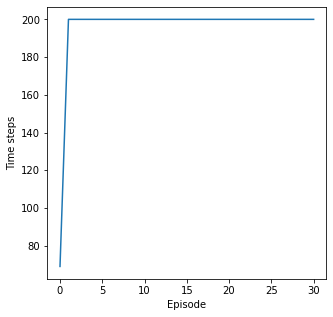

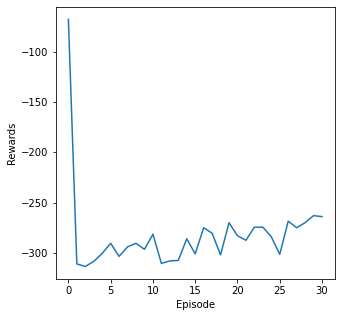

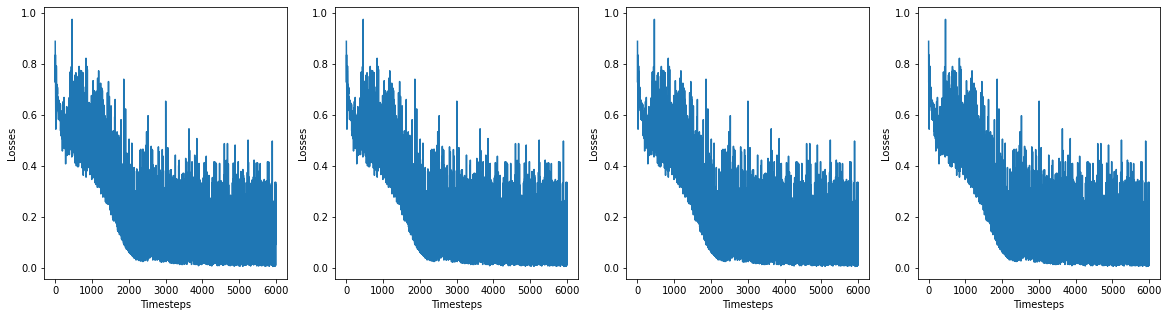

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(timesteps)
ax.set_ylabel("Time steps")
ax.set_xlabel("Episode")
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(rewards)
ax.set_ylabel("Rewards")
ax.set_xlabel("Episode")
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for i, key in enumerate(losses):
    flattened_loss = [loss for episode_loss in losses["total"] for loss in episode_loss]
    ax[i].plot(flattened_loss, label=key)
    ax[i].set_ylabel("Losses")
    ax[i].set_xlabel("Timesteps")
plt.show()
